In [2]:
import skfem as fem
from skfem.helpers import dot, grad, d, dd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as scisparse
from scipy.stats import truncnorm
import scipy.optimize as sciopt
import scipy.linalg as sl
from tqdm import tqdm
import pymc as pm
import seaborn as sns

# Data From the True Model

Consider the linear, 1D Poisson Equation with dirichlet boundary conditions on the unit interval,

$$ -\Delta u = -u'' = f(x) \quad u(0)=u(1)=0. $$

In [3]:
number_of_x_axial_cells = 200

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

/home/danielclaassen/anaconda3/envs/fenicsproject/lib/python3.12/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


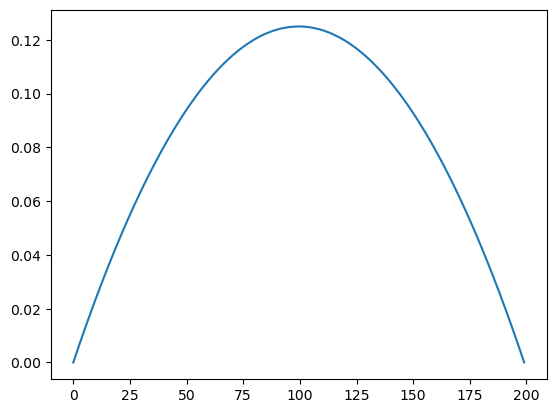

In [5]:
true_alpha = 1.
true_beta = 1.

@fem.LinearForm
def RHS(v,w):
    x = w.x
    f = true_beta
    return f*v

@fem.BilinearForm
def LHS(u,v,w):
    x = w.x
    return true_alpha*dot(grad(u),grad(v))

A_mat = LHS.assemble(basis)
A_mat[boundary_indices,:] = 0.
A_mat[boundary_indices, boundary_indices] = 1.
L_vec = RHS.assemble(basis)
L_vec[boundary_indices] = 0.

true_u_solution = scisparse.linalg.spsolve(A_mat, L_vec)
plt.plot(true_u_solution)
plt.show()

Now that we have the solution or 'true model' in `u_solution`, we should generate data by perturbing it a bit.

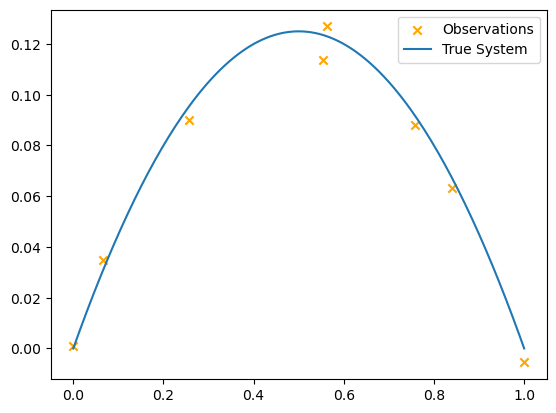

In [6]:
n_obs = 8
include_endpoints = True

true_sigma_n = 0.005

if include_endpoints == True:
    observation_indices = np.zeros(n_obs, dtype='int64')
    observation_indices[:2] = boundary_indices
    observation_indices[2:] = np.random.choice(np.arange(1, n_x-1), len(observation_indices[2:]), replace=False)
    observation_indices = np.sort(observation_indices)
    observation_coordinates = coordinates[observation_indices]
    observation_values = true_u_solution[observation_indices] + np.random.normal(0, true_sigma_n, len(observation_indices))

plt.scatter(observation_coordinates.flatten(), observation_values, label='Observations', color='orange', marker='x')
plt.plot(coordinates.flatten(), true_u_solution, label='True System')
plt.legend()
plt.show()


# Predicting Model
With a set of observations in hand, we use a predictive model with assumed model error. We then attempt to correct parameters to cater the model.

$$ -\alpha \Delta u = \beta + \xi_\theta $$

Where, $\alpha$ and $\beta$ are model parameters, the boundary conditions are assumed correct and our GP uses two hyperparameters inside its kernel function,

$$ \xi_\theta \sim \mathcal{GP}(0, k(x,x';\rho, \ell)) $$
$$ k(x, x';\rho, \ell) = \rho^2 \exp \left( -\frac{(x-x')^2}{2\ell^2} \right) $$

In [7]:
number_of_x_axial_cells = 200

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

true_coordinates = coordinates

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

u_0 = np.zeros(n_x)

def create_observation_operator_nearest(X, Y):
    H = np.zeros((len(Y), len(X)))
    for i, y in enumerate(Y):
        # Find the index of the nearest point in X to y
        nearest_index = np.argmin(np.abs(X - y))
        H[i, nearest_index] = 1
    return H

observation_operator = create_observation_operator_nearest(coordinates.flatten(), observation_coordinates.flatten())

In [8]:
import pytensor.tensor.subtensor as subtense
import pytensor.tensor as posttense

@fem.BilinearForm
def A_form(u,v,w):
    return dot(grad(u), grad(v))

@fem.BilinearForm
def M_form(u,v,w):
    return u*v

@fem.LinearForm
def L_form(v,w):
    return 1.*v

K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)

A_mat = (A_form.assemble(basis)).toarray()
L_vec = L_form.assemble(basis)
M_mat = (M_form.assemble(basis)).toarray()

def A_alpha_mat(alpha):
    A_alpha = alpha*A_mat
    A_alpha = subtense.set_subtensor(A_alpha[0,:], 0.)
    A_alpha = subtense.set_subtensor(A_alpha[-1,:], 0.)
    A_alpha = subtense.set_subtensor(A_alpha[0,0], 1.)
    A_alpha = subtense.set_subtensor(A_alpha[-1,-1], 1.)
    # A_alpha[0,:] = A_alpha[-1,:] = 0.
    # A_alpha[0,0] = A_alpha[-1,-1] = 1.
    return A_alpha

def L_beta_vec(beta):
    L_beta = beta*L_vec
    L_beta = subtense.set_subtensor(L_beta[0], 0.)
    L_beta = subtense.set_subtensor(L_beta[-1], 0.)
    # L_beta[0] = L_beta[-1] = 0.
    return L_beta

def G_theta_mat(rho, ell):
    G_vec = (rho**2)*posttense.math.exp(-posttense.nlinalg.norm(K_theta_1 - K_theta_2,axis=1)/(2*(ell**2)))
    return posttense.reshape(G_vec, (n_x, n_x))

def G_theta_mat_np(rho, ell):
    G_vec = (rho**2)*np.exp(-np.linalg.norm(K_theta_1 - K_theta_2,axis=1)/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))

In [9]:
with pm.Model() as model:
    alpha = pm.TruncatedNormal('alpha', mu=1, sigma=0.1, lower=0.0001)
    beta = pm.TruncatedNormal('beta', mu=1, sigma=0.1, lower=0.0001)
    rho = pm.TruncatedNormal('rho', mu=0.01, sigma=0.005, lower=0.0001)
    ell = pm.TruncatedNormal('ell', mu=1, sigma=0.1, lower=0.0001)
    sigma_n = pm.TruncatedNormal('sigma_n', mu=0.01, sigma=0.005, lower=0.0001)
    
    A_alpha = pm.Deterministic('A_alpha', A_alpha_mat(alpha))
    L_beta = pm.Deterministic('L_beta', L_beta_vec(beta))
    G_rho_ell = pm.Deterministic('G_rho_ell', M_mat @ G_theta_mat(rho, ell) @ M_mat.T)

    #A_alpha_inv = pm.Deterministic('A_alpha_inv', posttense.nlinalg.matrix_inverse(A_alpha))
    A_alpha_inv = posttense.nlinalg.matrix_inverse(A_alpha)

    # Q_mat, R_mat = posttense.nlinalg.qr(A_alpha)
    # Q_mat = pm.Deterministic('Q_mat', Q_mat)
    # R_mat = pm.Deterministic('R_mat', R_mat)
    # G_mat = pm.Deterministic('G_mat', M_mat @ G_rho_ell @ M_mat.T)
    # R_mat_inv = pm.Deterministic('R_mat_inv', posttense.nlinalg.tensorinv(R_mat))

    mu_u = pm.Deterministic('mu_u', A_alpha_inv @ L_beta)
    #mu_u = pm.Deterministic('mu_u', posttense.nlinalg.tensorsolve(R_mat, Q_mat.T @ L_beta))
    cov_u = pm.Deterministic('cov_u', A_alpha_inv @ G_rho_ell @ A_alpha_inv.T)
    #cov_u = pm.Deterministic('cov_u', R_mat_inv @ Q_mat.T @ G_mat @ Q_mat @ R_mat_inv.T)

    cov_chol = posttense.linalg.cholesky(observation_operator @ cov_u @ observation_operator.T + sigma_n**2 * np.eye(len(observation_values)))

    y_obs = pm.MvNormal('y_obs', mu = observation_operator @ mu_u, chol = cov_chol, observed=observation_values)

    #trace = pm.sample(500, chains=4, target_accept=0.95)
    trace = pm.sample(100, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, rho, ell, sigma_n]


Output()

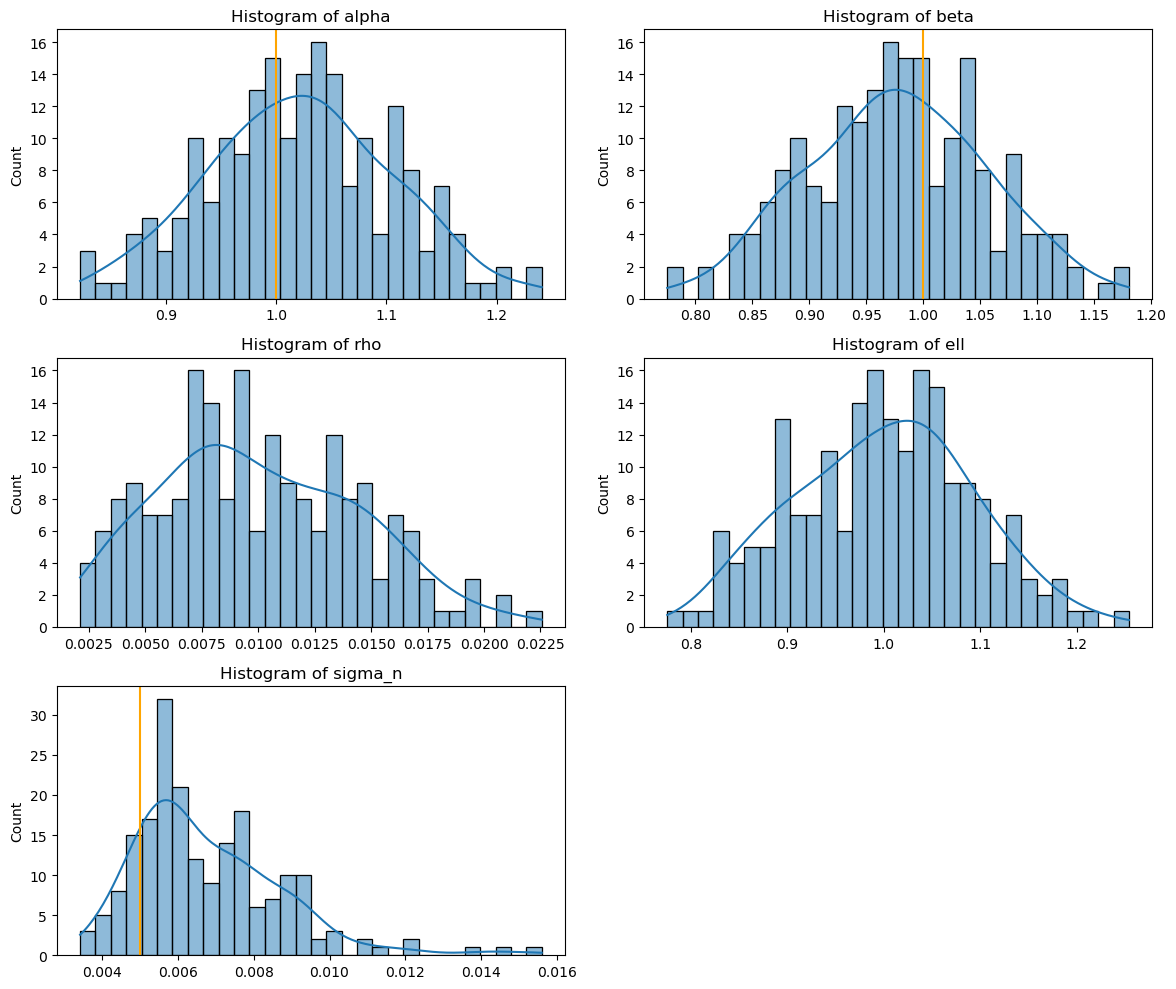

In [9]:
# Extracting samples from the trace
alpha_samples = trace.posterior['alpha'].data
beta_samples = trace.posterior['beta'].data
rho_samples = trace.posterior['rho'].data
ell_samples = trace.posterior['ell'].data
sigma_n_samples = trace.posterior['sigma_n'].data

# Plotting histograms
plt.figure(figsize=(12, 10))

bins_num = 30

plt.subplot(3, 2, 1)
sns.histplot(alpha_samples.flatten(), bins=bins_num, kde=True)
plt.axvline(true_alpha, color='orange', label='True Value')
plt.title('Histogram of alpha')

plt.subplot(3, 2, 2)
sns.histplot(beta_samples.flatten(), bins=bins_num, kde=True)
plt.axvline(true_beta, color='orange', label='True Value')
plt.title('Histogram of beta')

plt.subplot(3, 2, 3)
sns.histplot(rho_samples.flatten(), bins=bins_num, kde=True)
plt.title('Histogram of rho')

plt.subplot(3, 2, 4)
sns.histplot(ell_samples.flatten(), bins=bins_num, kde=True)
plt.title('Histogram of ell')

plt.subplot(3, 2, 5)
sns.histplot(sigma_n_samples.flatten(), bins=bins_num, kde=True)
plt.axvline(true_sigma_n, color='orange', label='True Value')
plt.title('Histogram of sigma_n')

plt.tight_layout()
plt.show()


In [10]:
estimated_alpha = np.mean(trace.posterior['alpha'].data.flatten())
estimated_beta = np.mean(trace.posterior['beta'].data.flatten())
estimated_rho = np.mean(trace.posterior['rho'].data.flatten())
estimated_ell = np.mean(trace.posterior['ell'].data.flatten())
estimated_sigma_n = np.mean(trace.posterior['sigma_n'].data.flatten())

estimated_A_alpha_mat = estimated_alpha * A_mat
estimated_A_alpha_mat[0,:] = estimated_A_alpha_mat[-1,:] = 0.
estimated_A_alpha_mat[0,0] = estimated_A_alpha_mat[-1,-1] = 1.

inverse_estimated_A_alpha_mat = np.linalg.inv(estimated_A_alpha_mat)

estimated_L_beta_vec = estimated_beta * L_vec
estimated_L_beta_vec[0] = estimated_L_beta_vec[-1] = 0.

estimated_mu_u = np.linalg.solve(estimated_A_alpha_mat, estimated_L_beta_vec)
estimated_cov = inverse_estimated_A_alpha_mat @ M_mat @ G_theta_mat_np(estimated_rho, estimated_ell) @ M_mat.T @ inverse_estimated_A_alpha_mat.T

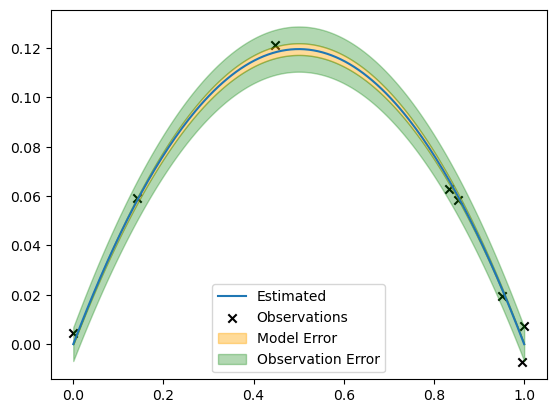

In [11]:
def plot_solution(estimated_mu, estimated_cov, sigma_n):
    plt.plot(coordinates, estimated_mu, label='Estimated')
    plt.scatter(observation_coordinates, observation_values, label='Observations', marker='x', color='black')
    plt.fill_between(coordinates.flatten(), estimated_mu + 2*np.sqrt(np.diag(estimated_cov)), estimated_mu - 2*np.sqrt(np.diag(estimated_cov)), color='orange', alpha=0.4, label='Model Error')
    plt.fill_between(coordinates.flatten(), estimated_mu + 2*np.sqrt(np.diag(estimated_cov)), estimated_mu + 2*np.sqrt(np.diag(estimated_cov))+ estimated_sigma_n*np.ones(len(coordinates.flatten())), alpha=0.3, color='green', label='Observation Error')
    plt.fill_between(coordinates.flatten(), estimated_mu - 2*np.sqrt(np.diag(estimated_cov)), estimated_mu - 2*np.sqrt(np.diag(estimated_cov))- estimated_sigma_n*np.ones(len(coordinates.flatten())), alpha=0.3, color='green')
    plt.legend()
    plt.show()

plot_solution(estimated_mu_u, estimated_cov, estimated_sigma_n)

# Misspecified Model

In [3]:
number_of_x_axial_cells = 200

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

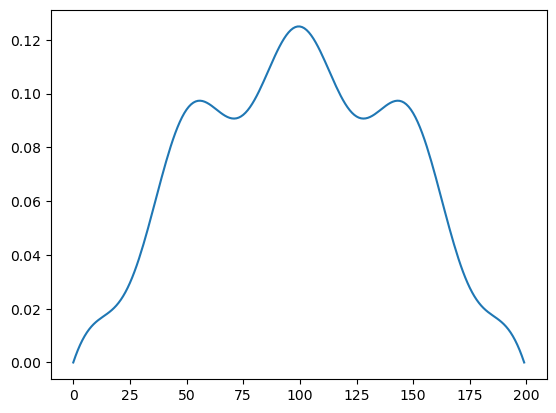

In [26]:
true_alpha = 1.
true_beta = 1.

@fem.LinearForm
def RHS(v,w):
    x = w.x
    f =  8 * np.cos(np.pi*8*x[0]) + true_beta
    return f*v

@fem.BilinearForm
def LHS(u,v,w):
    x = w.x
    return true_alpha*dot(grad(u),grad(v))

A_mat = LHS.assemble(basis)
A_mat[boundary_indices,:] = 0.
A_mat[boundary_indices, boundary_indices] = 1.
L_vec = RHS.assemble(basis)
L_vec[boundary_indices] = 0.

true_u_solution = scisparse.linalg.spsolve(A_mat, L_vec)
plt.plot(true_u_solution)
plt.show()

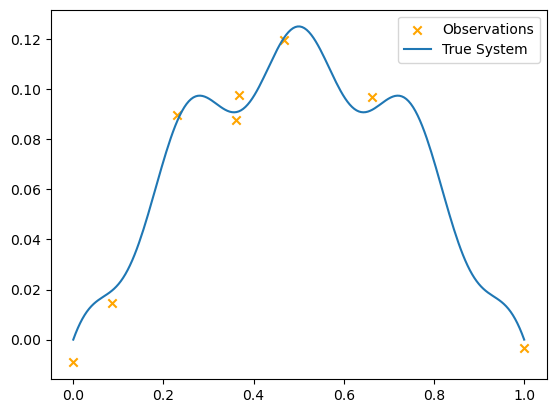

In [28]:
n_obs = 8
include_endpoints = True

true_sigma_n = 0.005

if include_endpoints == True:
    observation_indices = np.zeros(n_obs, dtype='int64')
    observation_indices[:2] = boundary_indices
    observation_indices[2:] = np.random.choice(np.arange(1, n_x-1), len(observation_indices[2:]), replace=False)
    observation_indices = np.sort(observation_indices)
    observation_coordinates = coordinates[observation_indices]
    observation_values = true_u_solution[observation_indices] + np.random.normal(0, true_sigma_n, len(observation_indices))

plt.scatter(observation_coordinates.flatten(), observation_values, label='Observations', color='orange', marker='x')
plt.plot(coordinates.flatten(), true_u_solution, label='True System')
plt.legend()
plt.show()


# Misspecified Model

In [32]:
number_of_x_axial_cells = 200

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

true_coordinates = coordinates

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

u_0 = np.zeros(n_x)

def create_observation_operator_nearest(X, Y):
    H = np.zeros((len(Y), len(X)))
    for i, y in enumerate(Y):
        # Find the index of the nearest point in X to y
        nearest_index = np.argmin(np.abs(X - y))
        H[i, nearest_index] = 1
    return H

observation_operator = create_observation_operator_nearest(coordinates.flatten(), observation_coordinates.flatten())

In [33]:
import pytensor.tensor.subtensor as subtense
import pytensor.tensor as posttense

@fem.BilinearForm
def A_form(u,v,w):
    return dot(grad(u), grad(v))

@fem.BilinearForm
def M_form(u,v,w):
    return u*v

@fem.LinearForm
def L_form(v,w):
    return 1.*v

K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)

A_mat = (A_form.assemble(basis)).toarray()
L_vec = L_form.assemble(basis)
M_mat = (M_form.assemble(basis)).toarray()

def A_alpha_mat(alpha):
    A_alpha = alpha*A_mat
    A_alpha = subtense.set_subtensor(A_alpha[0,:], 0.)
    A_alpha = subtense.set_subtensor(A_alpha[-1,:], 0.)
    A_alpha = subtense.set_subtensor(A_alpha[0,0], 1.)
    A_alpha = subtense.set_subtensor(A_alpha[-1,-1], 1.)
    # A_alpha[0,:] = A_alpha[-1,:] = 0.
    # A_alpha[0,0] = A_alpha[-1,-1] = 1.
    return A_alpha

def L_beta_vec(beta):
    L_beta = beta*L_vec
    L_beta = subtense.set_subtensor(L_beta[0], 0.)
    L_beta = subtense.set_subtensor(L_beta[-1], 0.)
    # L_beta[0] = L_beta[-1] = 0.
    return L_beta

def G_theta_mat(rho, ell):
    G_vec = (rho**2)*posttense.math.exp(-posttense.nlinalg.norm(K_theta_1 - K_theta_2,axis=1)/(2*(ell**2)))
    return posttense.reshape(G_vec, (n_x, n_x))

def G_theta_mat_np(rho, ell):
    G_vec = (rho**2)*np.exp(-np.linalg.norm(K_theta_1 - K_theta_2,axis=1)/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))

In [34]:
with pm.Model() as model:
    alpha = pm.TruncatedNormal('alpha', mu=1.5, sigma=0.5, lower=0.0001)
    beta = pm.TruncatedNormal('beta', mu=0.5, sigma=0.5, lower=0.0001)
    rho = pm.TruncatedNormal('rho', mu=0.1, sigma=0.01, lower=0.0001)
    ell = pm.TruncatedNormal('ell', mu=1, sigma=0.1, lower=0.0001)
    sigma_n = pm.TruncatedNormal('sigma_n', mu=0.01, sigma=0.005, lower=0.0001)
    
    A_alpha = pm.Deterministic('A_alpha', A_alpha_mat(alpha))
    L_beta = pm.Deterministic('L_beta', L_beta_vec(beta))
    G_rho_ell = pm.Deterministic('G_rho_ell', M_mat @ G_theta_mat(rho, ell) @ M_mat.T)

    #A_alpha_inv = pm.Deterministic('A_alpha_inv', posttense.nlinalg.matrix_inverse(A_alpha))
    A_alpha_inv = posttense.nlinalg.matrix_inverse(A_alpha)

    # Q_mat, R_mat = posttense.nlinalg.qr(A_alpha)
    # Q_mat = pm.Deterministic('Q_mat', Q_mat)
    # R_mat = pm.Deterministic('R_mat', R_mat)
    # G_mat = pm.Deterministic('G_mat', M_mat @ G_rho_ell @ M_mat.T)
    # R_mat_inv = pm.Deterministic('R_mat_inv', posttense.nlinalg.tensorinv(R_mat))

    mu_u = pm.Deterministic('mu_u', A_alpha_inv @ L_beta)
    #mu_u = pm.Deterministic('mu_u', posttense.nlinalg.tensorsolve(R_mat, Q_mat.T @ L_beta))
    cov_u = pm.Deterministic('cov_u', A_alpha_inv @ G_rho_ell @ A_alpha_inv.T)
    #cov_u = pm.Deterministic('cov_u', R_mat_inv @ Q_mat.T @ G_mat @ Q_mat @ R_mat_inv.T)

    cov_chol = posttense.linalg.cholesky(observation_operator @ cov_u @ observation_operator.T + sigma_n**2 * np.eye(len(observation_values)))

    y_obs = pm.MvNormal('y_obs', mu = observation_operator @ mu_u, chol = cov_chol, observed=observation_values)

    #trace = pm.sample(500, chains=4, target_accept=0.95)
    trace = pm.sample(100, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, rho, ell, sigma_n]


Output()

Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 508 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


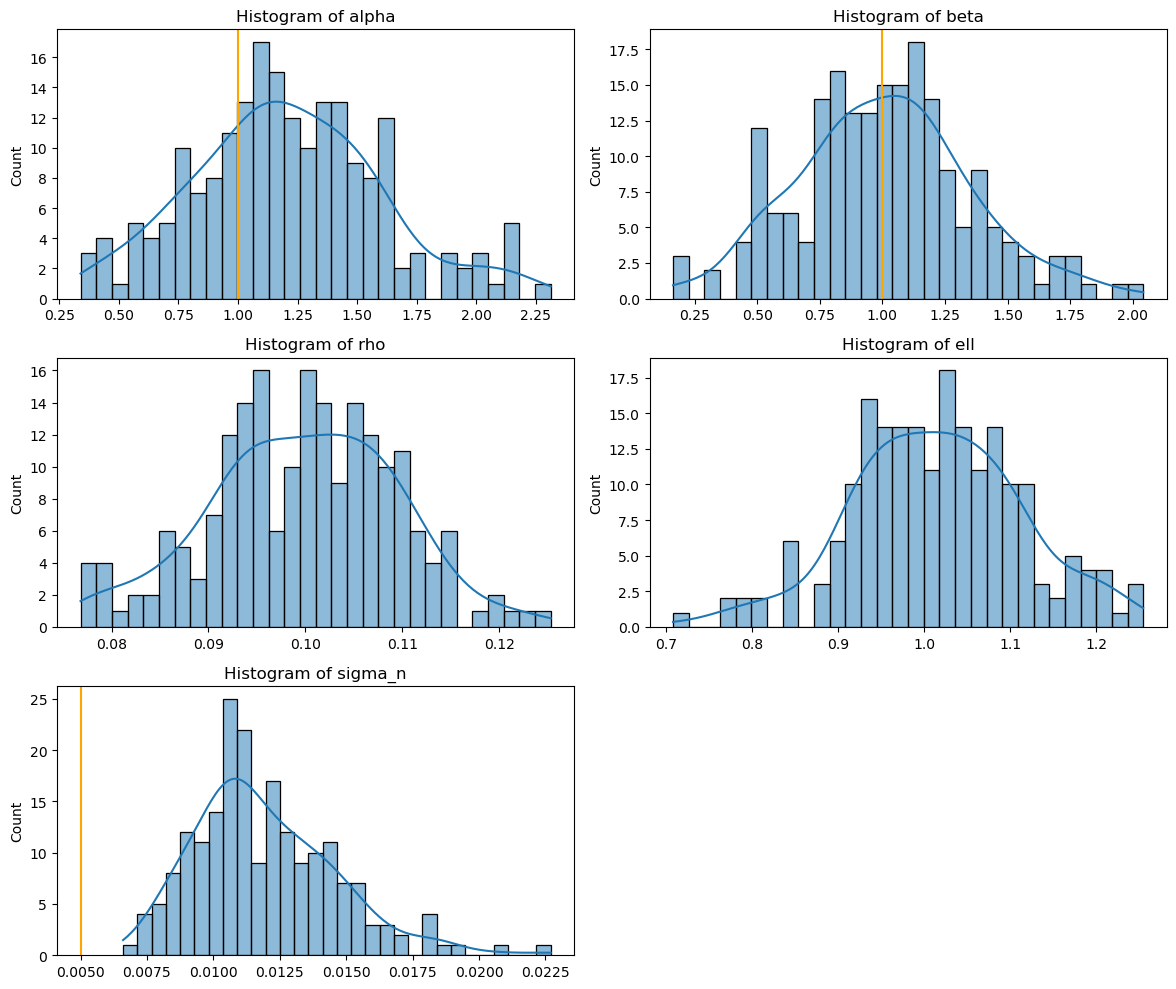

In [35]:
# Extracting samples from the trace
alpha_samples = trace.posterior['alpha'].data
beta_samples = trace.posterior['beta'].data
rho_samples = trace.posterior['rho'].data
ell_samples = trace.posterior['ell'].data
sigma_n_samples = trace.posterior['sigma_n'].data

# Plotting histograms
plt.figure(figsize=(12, 10))

bins_num = 30

plt.subplot(3, 2, 1)
sns.histplot(alpha_samples.flatten(), bins=bins_num, kde=True)
plt.axvline(true_alpha, color='orange', label='True Value')
plt.title('Histogram of alpha')

plt.subplot(3, 2, 2)
sns.histplot(beta_samples.flatten(), bins=bins_num, kde=True)
plt.axvline(true_beta, color='orange', label='True Value')
plt.title('Histogram of beta')

plt.subplot(3, 2, 3)
sns.histplot(rho_samples.flatten(), bins=bins_num, kde=True)
plt.title('Histogram of rho')

plt.subplot(3, 2, 4)
sns.histplot(ell_samples.flatten(), bins=bins_num, kde=True)
plt.title('Histogram of ell')

plt.subplot(3, 2, 5)
sns.histplot(sigma_n_samples.flatten(), bins=bins_num, kde=True)
plt.axvline(true_sigma_n, color='orange', label='True Value')
plt.title('Histogram of sigma_n')

plt.tight_layout()
plt.show()


In [36]:
estimated_alpha = np.mean(trace.posterior['alpha'].data.flatten())
estimated_beta = np.mean(trace.posterior['beta'].data.flatten())
estimated_rho = np.mean(trace.posterior['rho'].data.flatten())
estimated_ell = np.mean(trace.posterior['ell'].data.flatten())
estimated_sigma_n = np.mean(trace.posterior['sigma_n'].data.flatten())

estimated_A_alpha_mat = estimated_alpha * A_mat
estimated_A_alpha_mat[0,:] = estimated_A_alpha_mat[-1,:] = 0.
estimated_A_alpha_mat[0,0] = estimated_A_alpha_mat[-1,-1] = 1.

inverse_estimated_A_alpha_mat = np.linalg.inv(estimated_A_alpha_mat)

estimated_L_beta_vec = estimated_beta * L_vec
estimated_L_beta_vec[0] = estimated_L_beta_vec[-1] = 0.

estimated_mu_u = np.linalg.solve(estimated_A_alpha_mat, estimated_L_beta_vec)
estimated_cov = inverse_estimated_A_alpha_mat @ M_mat @ G_theta_mat_np(estimated_rho, estimated_ell) @ M_mat.T @ inverse_estimated_A_alpha_mat.T

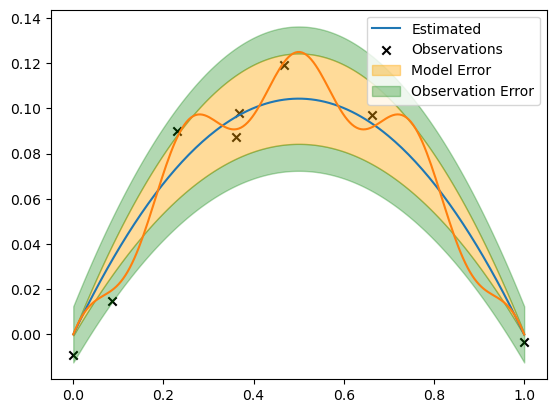

In [38]:
def plot_solution(estimated_mu, estimated_cov, sigma_n):
    plt.plot(coordinates, estimated_mu, label='Estimated')
    plt.scatter(observation_coordinates, observation_values, label='Observations', marker='x', color='black')
    plt.fill_between(coordinates.flatten(), estimated_mu + 2*np.sqrt(np.diag(estimated_cov)), estimated_mu - 2*np.sqrt(np.diag(estimated_cov)), color='orange', alpha=0.4, label='Model Error')
    plt.fill_between(coordinates.flatten(), estimated_mu + 2*np.sqrt(np.diag(estimated_cov)), estimated_mu + 2*np.sqrt(np.diag(estimated_cov))+ estimated_sigma_n*np.ones(len(coordinates.flatten())), alpha=0.3, color='green', label='Observation Error')
    plt.fill_between(coordinates.flatten(), estimated_mu - 2*np.sqrt(np.diag(estimated_cov)), estimated_mu - 2*np.sqrt(np.diag(estimated_cov))- estimated_sigma_n*np.ones(len(coordinates.flatten())), alpha=0.3, color='green')
    plt.plot(true_coordinates, true_u_solution)
    plt.legend()
    plt.show()

plot_solution(estimated_mu_u, estimated_cov, estimated_sigma_n)
